**TASK 1-Indian Sentiment analysis after 3 lockdowns using Tweets**

Team Name - Team Goal Achiever

Team Members :-

Divya Rajput
Harishankar Kumar

# Step1: Import Required Libraries

In [2]:
pip install preprocessor

  Created wheel for preprocessor: filename=preprocessor-1.1.3-cp36-none-any.whl size=4478 sha256=8f6461cbd9d6614b1f5bc774966ea559e9d1075ddc4e6d6d5284ecbd06afa6b7
  Stored in directory: /root/.cache/pip/wheels/98/c1/a2/21fbcfd80d76576bbf148991a66f00730f541f265c7600000f
Successfully built preprocessor


In [3]:
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Step2: Declare Variables For Twitter Credentials

In [0]:
#Twitter credentials for the app
consumer_key = 'ZiZqfc1gWoFp9DQZpz4j7uCQx'
consumer_secret = 'iJh3tedvla6dqFrnGhuT1tfrLjTnjKYhJRnmKQ370wtlaAJPV5'
access_key  = '1259189821832073223-Tk2t8AFZjyiHBfxcJuxodw9deHFQB2'
access_secret  = 'y5ZE6Wof6hBNQm1LcYC2uDCvG1ZvYiHmvR87sewMHmP35'
 
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)


# Step3: Define Necessary Paths and Variables

In [0]:

#file location changed to "data/telemedicine_data_extraction/" for clearer path
coronavirus_tweets = "coronavirus_data.csv"
 
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'original_author', 'possibly_sensitive', 'hashtags',
        'user_mentions', 'place', 'place_coord_boundaries']
 
#set two date variables for date range
start_date = '2020-01-20'
end_date = '2020-01-30'
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
 
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)
 


# Step4: Create Function To Clean Data

In [0]:
#mrhod clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
 
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
 
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)


# Step5: Function To Download Tweets and Save It

In [0]:

#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
 
 
           #tweepy preprocessing called for basic preprocessing
            clean_text = p.clean(status['text'])
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
 
            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])
 
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
 
            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")


# Step6: Declare #Keywords To Fetch From Twitter & Call Main Function

# Step7: Plot A WordCloud From The Tweets

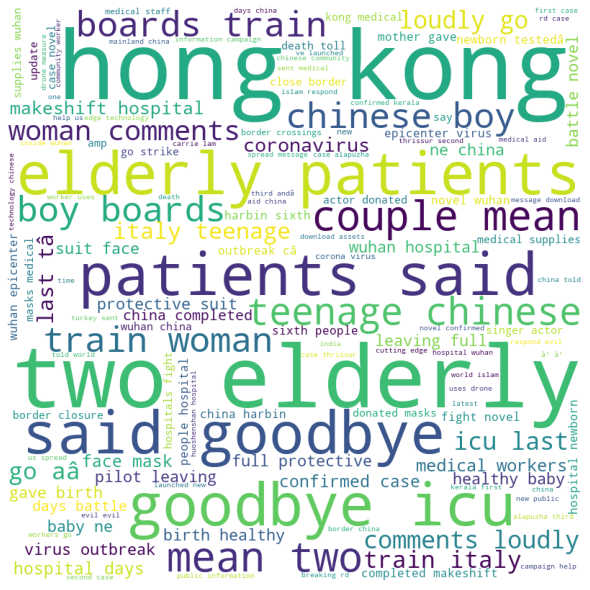

In [10]:
  
# Reads 'Youtube04-Eminem.csv' file
df = pd.read_csv(r"coronavirus_data.csv", encoding ="latin-1")

comment_words = " "
stopwords = set(STOPWORDS)

# iterate through the csv file 
for val in df.clean_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens:
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()